# Finding Blood Donors

## Overview

Blood donation is an extremely important contribution that a person can make towards the society because donating blood does not only save lives of people who need blood, it also has beneficial for donors themselves. Every day, people lose blood in accidents, injuries and surgeries, and then urgently need fresh blood to compensate for the loss so, there is a high demand for donors who are ready to donate their blood. 

Predicting if a donor will donate blood in the future can help in finding blood donation easily. Therefore, in this project, I will apply machine learning techniques on data collected from Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The goal of this project is to construct a model that predict whether or not a blood donor will give blood in future.

### Dataset

The dataset of this project originates from [UCI Machine Learning Repository](archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center).

* transfusion.data - The file contains a dataset from donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes their blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. The dataset contains 748 donors data, each donor has:

    * Recency (months) - months since last donation.
    * Frequency (Times) - total number of donation.
    * Monetary (c.c. blood) - total blood donated in cubic centimeter
    * Time (months) - months since first donation.
    * whether he/she donated blood in March 2007 - a binary variable representing whether he/she donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating blood).

The project is organized as follows. Section 1 explores and visualize the data. Section 2 includes data preperation and Section 3 implements the solution. Finally, Section 4 presents the summary.

## 1. Data Understanding

This step explores the dataset using different functions such as `head()`, `shape`, `describe()` , and checks the null values using `isnull()`.

In [1]:
# Import needed libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Read data in the file

df = pd.read_csv('transfusion.data')
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [3]:
# Rename columns 

df = df.rename(columns = {'Recency (months)': 'Recency', 'Frequency (times)': 'Frequency',
                          'Monetary (c.c. blood)': 'Monetary', 'Time (months)': 'Time',
                          'whether he/she donated blood in March 2007':'Class'})
df.head()

,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [4]:
df.shape

(748, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [6]:
df.describe()

,Recency,Frequency,Monetary,Time,Class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [7]:
# Check null values
df.isnull().sum()

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64

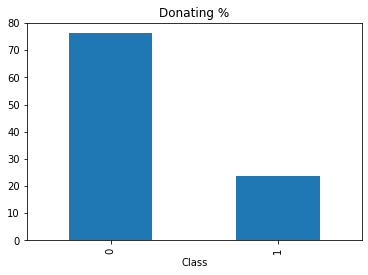

In [8]:
# Donating %
donated = df.groupby(['Class']).count()['Time']/df.shape[0] * 100
figure, ax = plt.subplots()
donated.plot(kind ='bar', title = 'Donating %', ax = ax);

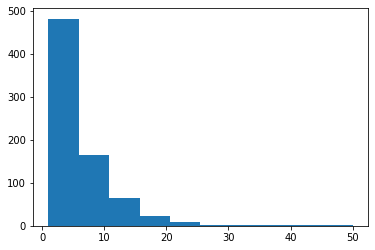

In [9]:
# Frequency of donation
plt.hist(df['Frequency']);

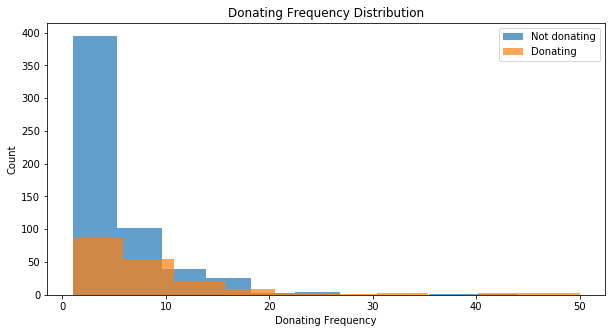

In [10]:
# Frequency of donation based on the class
figure, ax = plt.subplots(figsize = (10, 5))
ax.hist(df[df['Class'] == 0]['Frequency'], alpha = 0.7, label = 'Not donating')
ax.hist(df[df['Class'] == 1]['Frequency'],  alpha = 0.7, label = 'Donating')
plt.xlabel('Donating Frequency')
plt.ylabel('Count')
plt.title('Donating Frequency Distribution')
plt.legend()
plt.show()

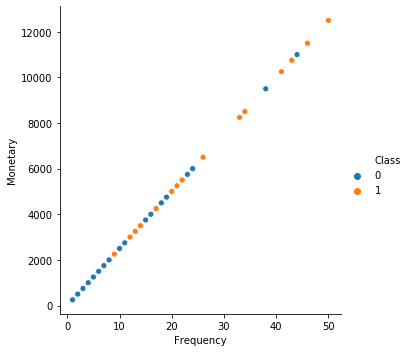

In [11]:
sns.relplot(x = 'Frequency', y = 'Monetary', data = df, hue = 'Class');

**Observations:**

From the data, we can see that:
* There is no missing or invalid values.
* Imbalance number of data in each class of the dataset.
* Most of the donors donated 1-5 times.
* Most of the donors who donated > 20 times in class 1. 
* Direct proportion between frequancy and monetary.



## 2. Data Preparation

This step includes cleaning data and data selection. For this dataset, there are no missing or invalid values, however, there are some qualities about certain features that should be adjusted. 

Now, I would like to calculate the difference between the last and first donation to use it as a feature. 

In [12]:
# Calculate the difference between months since first and last donation
df['Time_diff'] = df['Time'] - df['Recency']
df.head()

,Recency,Frequency,Monetary,Time,Class,Time_diff
0,2,50,12500,98,1,96
1,0,13,3250,28,1,28
2,1,16,4000,35,1,34
3,2,20,5000,45,1,43
4,1,24,6000,77,0,76


### 2.1. Feature Scaling

Now, I will normalize each numerical feature by using `MinMaxScaler()`.

In [13]:
# Initialize a scaler and apply it to the features
scaler = MinMaxScaler()
features = ['Recency', 'Frequency', 'Monetary', 'Time', 'Time_diff']
scaled_df = pd.DataFrame(data = df)
scaled_df[features] = scaler.fit_transform(df[features])
scaled_df.head()

,Recency,Frequency,Monetary,Time,Class,Time_diff
0,0.027027,1.000000,1.000000,1.000000,1,1.000000
1,0.000000,0.244898,0.244898,0.270833,1,0.291667
2,0.013514,0.306122,0.306122,0.343750,1,0.354167
3,0.027027,0.387755,0.387755,0.447917,1,0.447917
4,0.013514,0.469388,0.469388,0.781250,0,0.791667


### 2.2. Feature Selection

I will not use all features to build the ML model. I will create two groups (group 1 and group 2) of features and then see which one is the most suitable group to the model. 

#### 2.2.1 Features Group 1

This group contains *Recency*, *Frequency*, *Monetary* and *Time* features.

In [14]:
processed_df1 = scaled_df[['Recency', 'Frequency', 'Monetary', 'Time', 'Class']]
processed_df1.head()

,Recency,Frequency,Monetary,Time,Class
0,0.027027,1.000000,1.000000,1.000000,1
1,0.000000,0.244898,0.244898,0.270833,1
2,0.013514,0.306122,0.306122,0.343750,1
3,0.027027,0.387755,0.387755,0.447917,1
4,0.013514,0.469388,0.469388,0.781250,0


#### 2.2.2 Features Group 2

This group contains *Frequency*, *Monetary* and *Time_diff* features.

In [15]:
processed_df2 = scaled_df[['Frequency', 'Monetary','Time_diff', 'Class']]
processed_df2.head()

,Frequency,Monetary,Time_diff,Class
0,1.000000,1.000000,1.000000,1
1,0.244898,0.244898,0.291667,1
2,0.306122,0.306122,0.354167,1
3,0.387755,0.387755,0.447917,1
4,0.469388,0.469388,0.791667,0


## 3. Modeling

This step applies and evaluates different classification models, then enhance the models. 

### 3.1 Spalit Data

I will split the data into training and test sets, 80% for training and 20% for testing. *Class* feature is the target. 

#### 3.1.1 Features Group 1

In [16]:
# Initialize the features and class
X = processed_df1[['Recency', 'Frequency', 'Monetary', 'Time']]
y = processed_df1[['Class']]

# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### 3.1.2 Features Group 2

In [17]:
# Initialize the features and class
X2 = processed_df2[['Frequency', 'Monetary', 'Time_diff']]
y2 = processed_df2[['Class']]

# Split the data into training set and testing set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

### 3.2 Train and Evaluate Models

In [18]:
# Create a function to train a classifier 

def train_classifier(classifier, X_train, y_train, X_test, y_test): 
    
    """
    Function: train a classification algorithm.
    Args:
    classifier: the classification algorithm to be trained and predicted on
    X_train (dataframe): features training set
    y_train (dataframe): labels training set
    X_test (dataframe): features testing set
    y_test (dataframe): labels testing set
    """
    
    
    # Fit the classifier to the training data
    clf = classifier.fit(X_train, y_train)
        
    # Get the predictions on the test set
    predictions_test = clf.predict(X_test)
        
    # Compute accuracy on testing set 
    result = accuracy_score(y_test, predictions_test)
    print("{} training...".format(clf.__class__.__name__))

    return result

In [19]:
# Initialize the three models
clf_1 = DecisionTreeClassifier()
clf_2 = RandomForestClassifier(random_state = 0)
clf_3 = SVC(random_state = 0)

#### 3.1.1 Features Group 1

In [20]:
# train the models
for clf in [clf_1, clf_2, clf_3]:
    clf_name = clf.__class__.__name__
    result = train_classifier(clf, X_train, y_train, X_test, y_test)
    print()
    
# Evaluate the models
    print("Accuracy score on testing data: {:.4f}".format(result))
    print('------------')
    print()

DecisionTreeClassifier training...

Accuracy score on testing data: 0.7000
------------



C:\Users\missn\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier training...

Accuracy score on testing data: 0.7267
------------

SVC training...

Accuracy score on testing data: 0.7333
------------



C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 3.1.2 Features Group 2

In [21]:
# Train the models
for clf in [clf_1, clf_2, clf_3]:
    clf_name = clf.__class__.__name__
    result = train_classifier(clf, X_train2, y_train2, X_test2, y_test2)
    print()
    
# Evaluate the models
    print("Accuracy score on testing data: {:.4f}".format(result))
    print('------------')
    print()

DecisionTreeClassifier training...

Accuracy score on testing data: 0.6600
------------



C:\Users\missn\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier training...

Accuracy score on testing data: 0.7000
------------

SVC training...

Accuracy score on testing data: 0.7400
------------



C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 3.3 Improving Results

In this section, I will select the best models from the six supervised learning models to perform a grid search optimization.

The table below shows the accuracy of each model:

| Features Groups  | Decision Tree | Random Forest | SVM  | 
|---|---|---|---|
| Group 1  | 0.7000 | 0.7267 | 0.7333 |   
| Group 2  | 0.6600 | 0.7000 | 0.7400 |   
 
 
The best three models are:
* Features Group 1 with Random Forest.
* Features Group 1 with SVM.
* Features Group 2 with SVM.


Now, I will use grid search to optmize the best three models.

In [22]:
# Create a function to tune the model

def tune_model(classifier, X_train, y_train, X_test, y_test, parameters):
    
    """
    Function: fine-tune the classifier parameters to find the optimal parameters values. 
    Args:
    classifier: the classification algorithm 
    X_train (dataframe): features training set
    y_train (dataframe): labels training set
    X_test (dataframe): features testing set
    y_test (dataframe): labels testing set
    parameters (dictionary): parameters to be used in the grid search
    """
    results = {}
    
    # Make a scoring object 
    scorer = make_scorer(accuracy_score, greater_is_better = True)

    # Perform grid search on the classifier
    grid_obj = GridSearchCV(classifier, parameters, scoring = scorer)

    # Fit the grid search object 
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_
    best_params = grid_obj.best_params_

    # Make predictions 
    best_predictions = best_clf.predict(X_test)
    
    # Compute accuracy after tuning
    acc = accuracy_score(y_test, best_predictions)
    
    print("{} Tuning...".format(classifier.__class__.__name__))
    
    # Return the results
    return acc, best_params

#### 3.3.1 Random Forest - Features Group 1

In [23]:
# Initialize parameters for fine tuning
rf_parameters = {'max_depth': [5, 10, None],
 'min_samples_leaf':  [3, 4, 5],
 'min_samples_split': [2, 3],
 'criterion' : ['gini', 'entropy'],
 'n_estimators': [200, 500, 600, 700]}

# Apply grid search
rf_acc, rf_best_params = tune_model(clf_2, X_train, y_train, X_test, y_test, rf_parameters)

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

RandomForestClassifier Tuning...


In [24]:
# Print grid search best parametrs and scores
print("Best Parameters: {}".format(rf_best_params))
print("Accuracy score on testing data: {:.4f}".format(rf_acc))

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy score on testing data: 0.7800


#### 3.1.2 SVM - Features Group 1

In [25]:
# Initialize parameters for fine tuning
svm_parameters = {'kernel': ['linear', 'rbf', 'poly'], 
                  'C': [0.5, 1, 1.5], 
                  'gamma': ['scale', 'auto'] }

# Apply grid search
svm_acc, svm_best_params = tune_model(clf_3, X_train, y_train, X_test, y_test, svm_parameters)

C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

SVC Tuning...


In [26]:
# Print grid search best parametrs and scores
print("Best Parameters: {}".format(svm_best_params))
print("Accuracy score on testing data: {:.4f}".format(svm_acc))

Best Parameters: {'C': 1.5, 'gamma': 'scale', 'kernel': 'poly'}
Accuracy score on testing data: 0.7400


#### 3.1.3 SVM - Features Group 2

In [27]:
# Apply grid search
svm_acc, svm_best_params = tune_model(clf_3, X_train2, y_train2, X_test2, y_test2, svm_parameters)

C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\missn\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

SVC Tuning...


In [28]:
# Print grid search best parametrs and scores
print("Best Parameters: {}".format(svm_best_params))
print("Accuracy score on testing data: {:.4f}".format(svm_acc))

Best Parameters: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy score on testing data: 0.7267


### 3.4 Using Best Model

The accuracy score of each optmized model:
* Random Forest - Features Group 1: 0.7800
* SVM - Features Group 1: 0.7400
* SVM - Features Group 2: 0.7267

Random Forest with Features Group 1 gave the highest accuracy score.

In [32]:
# Using the best params in the model
rf_clf = RandomForestClassifier (criterion = 'gini', max_depth = 5, min_samples_leaf = 3,
                                 min_samples_split = 2, n_estimators = 200)

rf_clf = rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

# Print classification report
print ('Classification Report')
print ('---------------------')
print()
print(classification_report(y_test, rf_pred))
print()
print ('Confusion matrix')
print ('---------------------')
print()
print(confusion_matrix(y_test,rf_pred))

C:\Users\missn\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       109
           1       0.65      0.41      0.51        41

    accuracy                           0.78       150
   macro avg       0.73      0.67      0.68       150
weighted avg       0.76      0.78      0.76       150


Confusion matrix
---------------------

[[100   9]
 [ 24  17]]


From the classification report, we can see that the recall, precision and f1-score of class 1 data are lower than the class 0. This is because of highly imbalanced dataset. In general, the model give us good result. 

## 4. Summary

Blood donation is significant for saving lives of people who lost large amounts of blood. An accurate prediction of the future supply of blood help to take the right action to save people lives. In this project, I created different classification models to predict whether or not a blood donor will give blood in future. Then, I used parameter tuning to improve the models. Random forest classification algorithm gave the best accuracy (78%). 
    